# Analysis of appliances energy data
### The purpose of this exercise is to predict the appliance consumption based on the available time series data
### Data taken from https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction¶

####  Most of the columns provide temperature and relative humidity measurements. According to the data description:
#### `Attribute Information:`

#### date time year-month-day hour:minute:second
#### Appliances, energy use in Wh
#### lights, energy use of light fixtures in the house in Wh
#### T1, Temperature in kitchen area, in Celsius
#### RH_1, Humidity in kitchen area, in %
#### T2, Temperature in living room area, in Celsius
#### RH_2, Humidity in living room area, in %
#### T3, Temperature in laundry room area
#### RH_3, Humidity in laundry room area, in %
#### T4, Temperature in office room, in Celsius
#### RH_4, Humidity in office room, in %
#### T5, Temperature in bathroom, in Celsius
#### RH_5, Humidity in bathroom, in %
#### T6, Temperature outside the building (north side), in Celsius
#### RH_6, Humidity outside the building (north side), in %
#### T7, Temperature in ironing room , in Celsius
#### RH_7, Humidity in ironing room, in %
#### T8, Temperature in teenager room 2, in Celsius
#### RH_8, Humidity in teenager room 2, in %
#### T9, Temperature in parents room, in Celsius
#### RH_9, Humidity in parents room, in %
#### To, Temperature outside (from Chievres weather station), in Celsius
#### Pressure (from Chievres weather station), in mm Hg
#### RH_out, Humidity outside (from Chievres weather station), in %
#### Wind speed (from Chievres weather station), in m/s
#### Visibility (from Chievres weather station), in km
#### Tdewpoint (from Chievres weather station), Â°C
#### rv1, Random variable 1, nondimensional
#### rv2, Random variable 2, nondimensional


In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,RidgeCV,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE


In [66]:
data = pd.read_csv('energydata_complete.csv',delimiter=',')
# data = data
data.head()
data.describe()
data.columns
# print(data.shape)

Index(['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')

In [67]:
#Check for missing values
data.isnull().sum().sort_values(ascending = True)
print(f"Number of variables {data.shape[1]}")


Number of variables 29


### Since there are no null values in dataset, I do not need to fill up any missing values

In [68]:
## Check which variables are numerical
only_num = data.dtypes[data.dtypes != 'object'].index
only_obj = data.dtypes[data.dtypes == 'object'].index
print(f"Number of non-numerical variables: {only_obj.shape[0]} {only_obj}")



Number of non-numerical variables: 1 Index(['date'], dtype='object')


In [69]:
# Only one variable is non-numerical, that is date
# Creating a new variable that contains time

In [103]:
from datetime import datetime
times = [datetime.strptime(time, '%Y-%m-%d %H:%M:%S') for time in data.date]
time_stamps = [datetime.strptime(time, '%Y-%m-%d %H:%M:%S').timestamp() for time in data.date]
data["unixtime"] = time_stamps
data["time"] = times # [t.timestamp() for t in times]

In [106]:
print(data["time"].head(5))
print("----")
print(data.time.astype('int64').head(5))
#pd.to_timedelta(data['time'], unit='ns').dt.total_seconds().astype(int)
print("----")
print(data.unixtime.astype("int64").head(5))

0   2016-01-11 17:00:00
1   2016-01-11 17:10:00
2   2016-01-11 17:20:00
3   2016-01-11 17:30:00
4   2016-01-11 17:40:00
Name: time, dtype: datetime64[ns]
----
0    1452531600000000000
1    1452532200000000000
2    1452532800000000000
3    1452533400000000000
4    1452534000000000000
Name: time, dtype: int64
----
0    1452528000
1    1452528600
2    1452529200
3    1452529800
4    1452530400
Name: unixtime, dtype: int64


### Check for any correlations

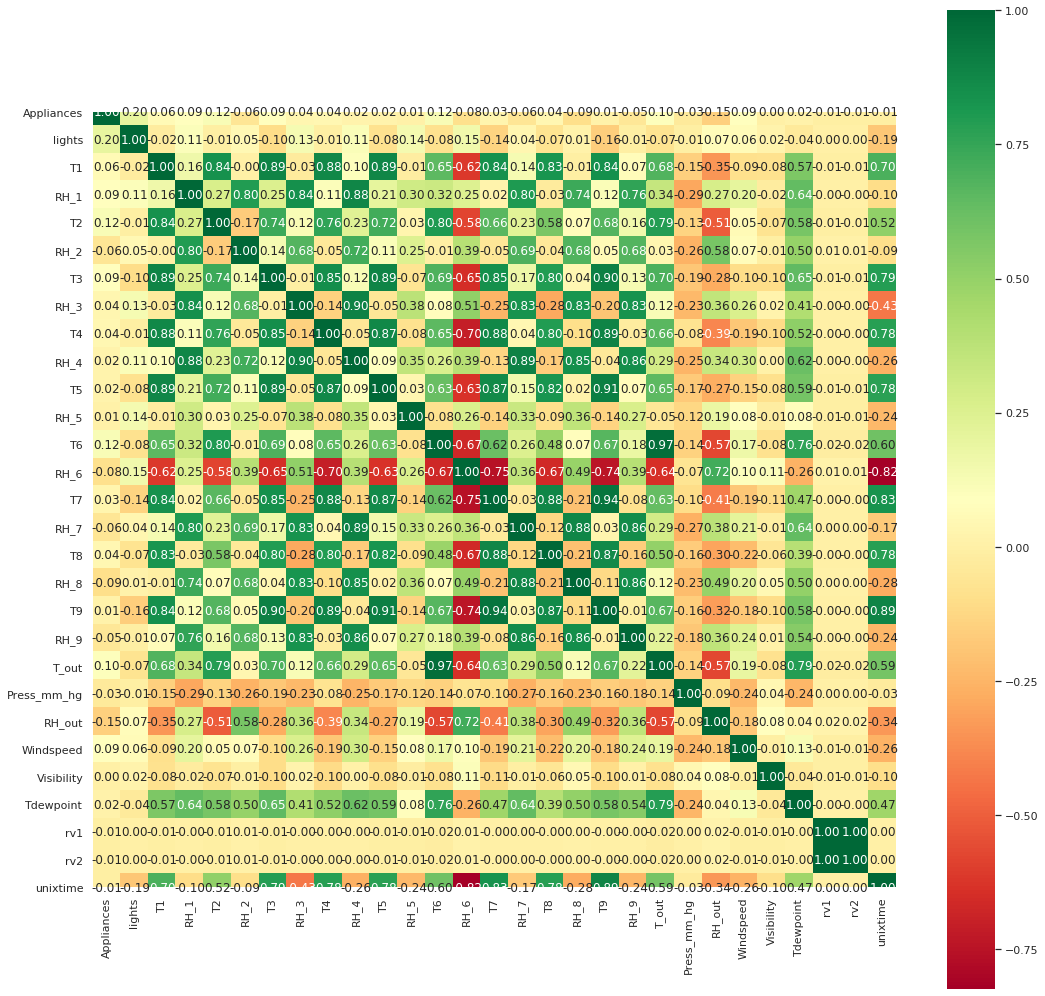

In [107]:
import seaborn as sns
# plt.figure(figsize=(15,10))  
# sns.heatmap(data.corr(),annot=True,linewidths=.5, cmap="Blues")
# plt.title('Heatmap showing correlations between numerical data')
# plt.show()

corr = data.corr()
plt.figure(figsize = (18,18))
sns.set(font_scale=1)
sns.heatmap(corr, cbar = True, annot=True, square = True,cmap="RdYlGn", fmt = '.2f')
plt.show();


In [108]:
### It is very damn hard to see anything


In [109]:
# I select these columns as features. Splitting in different sections for later testing
# Good practire reminder: make all columns lowercase to avoid any confusion on names!
temp_cols = ["T"+str(col) for col in range(1,10)]
hum_cols = ["RH_"+str(col) for col in range(1,10)]
weather_cols = ["T_out", "Tdewpoint","RH_out","Press_mm_hg","Windspeed","Visibility"]
light_col = ["lights"]
random_cols = ["rv1", "rv2"]
target_col = ["Appliances"]
target_col = ["log_appliances"]


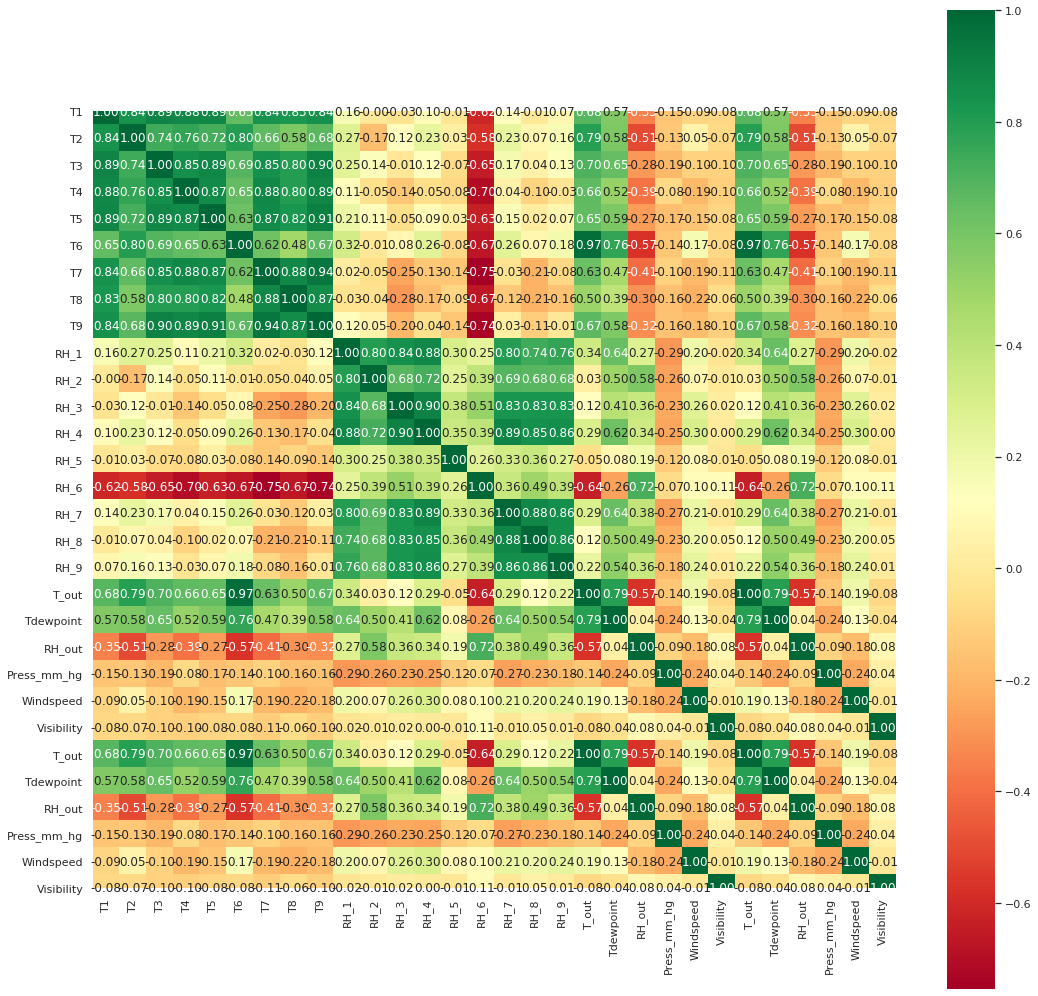

In [110]:
#Checking again for correlations with this subset
corr = data[temp_cols+hum_cols+weather_cols+weather_cols].corr()
plt.figure(figsize = (18,18))
sns.set(font_scale=1)
sns.heatmap(corr, cbar = True, annot=True, square = True,cmap="RdYlGn", fmt = '.2f')
plt.show();

In [117]:
# Checking for correlation with Appliances
all_corrs= data.corrwith(data["Appliances"]).abs().sort_values(ascending=False)
temp_corrs = data[temp_cols].corrwith(data["Appliances"]).abs().sort_values(ascending=False)
hum_corrs = data[hum_cols].corrwith(data["Appliances"]).abs().sort_values(ascending=False)
weather_corrs = data[weather_cols].corrwith(data["Appliances"]).abs().sort_values(ascending=False)
print("All correlations")
print(all_corrs)
print("Correlations for temp")
print(temp_corrs)
print("Correlations for hum")
print(hum_corrs)
print("Correlations for weather")
print(weather_corrs)
time_corr=data[["unixtime"]].corrwith(data["Appliances"])
print(f"Corr with time {time_corr}")

All correlations
Appliances     1.000000
lights         0.197278
RH_out         0.152282
T2             0.120073
T6             0.117638
T_out          0.099155
RH_8           0.094039
Windspeed      0.087122
RH_1           0.086031
T3             0.085060
RH_6           0.083178
RH_2           0.060465
RH_7           0.055642
T1             0.055447
RH_9           0.051462
T4             0.040281
T8             0.039572
RH_3           0.036292
Press_mm_hg    0.034885
T7             0.025801
T5             0.019760
RH_4           0.016965
Tdewpoint      0.015353
rv2            0.011145
rv1            0.011145
T9             0.010010
unixtime       0.009628
RH_5           0.006955
Visibility     0.000230
dtype: float64
Correlations for temp
T2    0.120073
T6    0.117638
T3    0.085060
T1    0.055447
T4    0.040281
T8    0.039572
T7    0.025801
T5    0.019760
T9    0.010010
dtype: float64
Correlations for hum
RH_8    0.094039
RH_1    0.086031
RH_6    0.083178
RH_2    0.060465
RH_7    0.0

In [ ]:
# from datetime import datetime
# times = [datetime.strptime(time, '%Y-%m-%d %H:%M:%S') for time in data.date]
# data["time"] = times # [t.timestamp() for t in times]

/home/cap/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/cap/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/cap/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


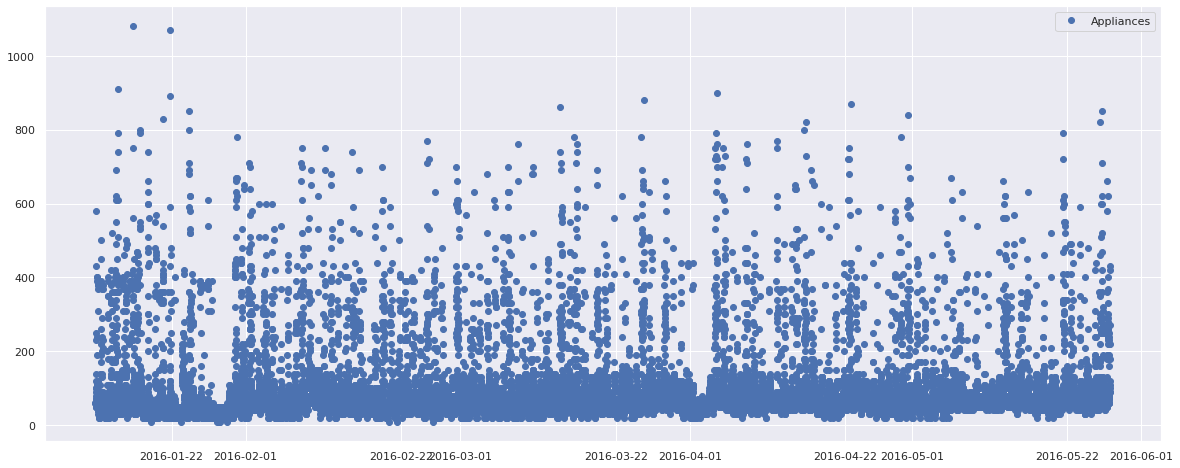

In [118]:
# Having a look at how the Appliances variable looks like
fig = plt.figure(figsize=(20,8))
plt.plot_date(data["time"],data["Appliances"],label='Appliances',color='b')
plt.legend(loc=1)


In [119]:
data.columns

Index(['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2', 'time', 'unixtime'],
      dtype='object')

In [120]:
# Making the Appliances variable logarithmic, since the values are usually large

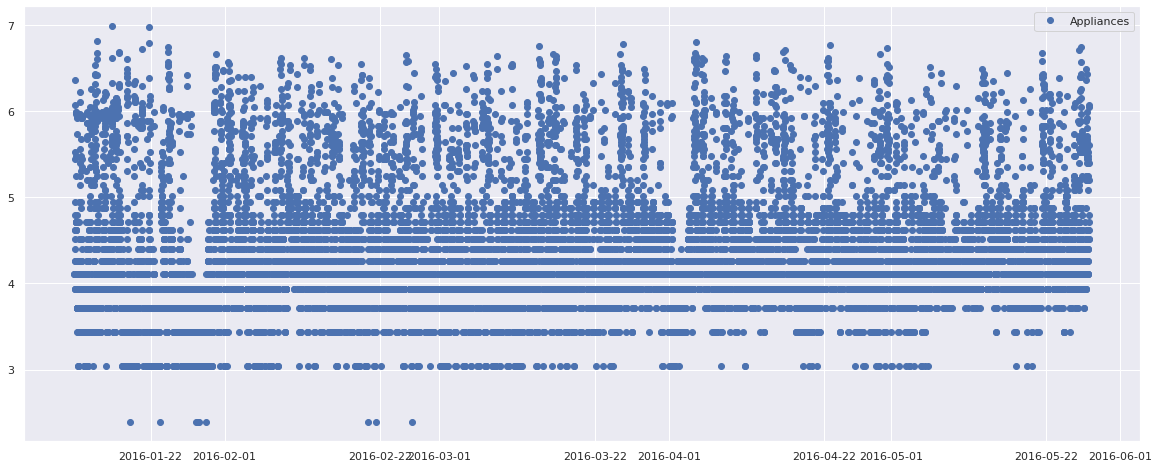

In [121]:

data["log_appliances"] = np.log1p(data["Appliances"])

fig = plt.figure(figsize=(20,8))
plt.plot_date(data["time"],data["log_appliances"],label='Appliances',color='b')
plt.legend(loc=1)


### Tried including date info to dataset, but models turned out to be quite poor.
### I probably need to convert it to something more sensible (hours?), since Appliances
### consumption should be correlated wit that. But did not have time to dig more on this.
### In the end I decided to drop this variable.
### It might be more sensible to make the prediction for hourly time steps, since
### Appliances changes a lot in 10 minutes intervals!


In [122]:
data.drop("date",axis=1)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,time,unixtime,log_appliances
0,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,45.566667,...,733.5,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433,2016-01-11 17:00:00,1.452528e+09,4.110874
1,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,45.992500,...,733.6,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195,2016-01-11 17:10:00,1.452529e+09,4.110874
2,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,45.890000,...,733.7,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668,2016-01-11 17:20:00,1.452529e+09,3.931826
3,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,45.723333,...,733.8,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389,2016-01-11 17:30:00,1.452530e+09,3.931826
4,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,45.530000,...,733.9,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097,2016-01-11 17:40:00,1.452530e+09,4.110874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,45.590000,...,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812,2016-05-27 17:20:00,1.464362e+09,4.615121
19731,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,45.590000,...,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940,2016-05-27 17:30:00,1.464363e+09,4.510860
19732,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,45.730000,...,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117,2016-05-27 17:40:00,1.464364e+09,5.602119
19733,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,45.790000,...,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784,2016-05-27 17:50:00,1.464364e+09,6.042633


### Splitting the data

In [123]:
# The usual data split. Note I did attempt using the shuffle=False option below,
# but for some reason got some weird results. I think it is before my time data
# should be in some more relevant units. See also comment above, where I dropped the time variable.
# My choice of random_state is completely random, I just like the number...

df_train_full, df_test = train_test_split(data, test_size=0.2,random_state=42) #,shuffle=False)
df_train, df_val = train_test_split(df_train_full, test_size=0.25,random_state=42) #shuffle=False


feature_cols = temp_cols + hum_cols + weather_cols + light_col #+ random_cols
print(f"Using {len(feature_cols)} features: {feature_cols}")
print(temp_cols)

print(hum_cols)
X_train = df_train[feature_cols]
y_train = df_train[target_col].values


X_val = df_val[feature_cols]
y_val = df_val[target_col].values

#This to be used at the end!!!
X_test = df_test[feature_cols]
y_test = df_test[target_col].values

print(f"X_train {X_train.shape}")

print(f"X_test {X_test.shape}")
print(f"X_val {X_val.shape}")


Using 25 features: ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'RH_1', 'RH_2', 'RH_3', 'RH_4', 'RH_5', 'RH_6', 'RH_7', 'RH_8', 'RH_9', 'T_out', 'Tdewpoint', 'RH_out', 'Press_mm_hg', 'Windspeed', 'Visibility', 'lights']
['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9']
['RH_1', 'RH_2', 'RH_3', 'RH_4', 'RH_5', 'RH_6', 'RH_7', 'RH_8', 'RH_9']
X_train (11841, 25)
X_test (3947, 25)
X_val (3947, 25)


### Model setup, with training data

In [124]:
## Testing normalizing the data here, but I do not believe it had any effect in the end
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

## Somone suggested testing dimensionality reduction, but this did not improve my results
# from sklearn.decomposition import PCA


# pca = PCA()
# pca.fit(X_train)
# X_train = pca.transform(X_train) 
# X_test = pca.transform(X_test)
# X_val = pca.transform(X_val)



In [125]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

### Model selection using validation data
### Using mse, rmse and R2 corr as measuring scores

In [126]:
mse = []
r2 = []
rmse_val = []
models = ['LinearRegression','Ridge','Lasso','DecisionTreeRegressor','RandomForestRegressor',"SVR","GradientBoostingRegressor"]




## Linear Regression

lm = LinearRegression()
lm.fit(X_train,y_train)
y_pred = lm.predict(X_val)
score = r2_score(y_val,y_pred)
print(f"score for linear regression on validation data: {score}")
mse.append(mean_absolute_error(y_val,y_pred))
r2.append(r2_score(y_val,y_pred))
rmse_val.append(rmse(y_val,y_pred))


## Ridge Regression
rd = Ridge()
rd.fit(X_train,y_train)
y_pred = rd.predict(X_val)
score = r2_score(y_val,y_pred)
print(f"score for Ridge regression on validation data: {score}")
mse.append(mean_absolute_error(y_val,y_pred))
r2.append(r2_score(y_val,y_pred))
rmse_val.append(rmse(y_val,y_pred))

# print(mse)


## Lasso Regression
ls = Lasso()
ls.fit(X_train,y_train)
y_pred = ls.predict(X_val)
score = r2_score(y_val,y_pred)
print(f"score for Lasso regression on validation data: {score}")
mse.append(mean_absolute_error(y_val,y_pred))
r2.append(r2_score(y_val,y_pred))
rmse_val.append(rmse(y_val,y_pred))
# r2.append(r2_score(y_val,y_pred))
# rmse_val.append(rmse(y_val,y_pred))

# print(mse)


## Decision Tree Regressor
dtr = DecisionTreeRegressor()
dtr.fit(X_train,y_train)
y_pred = ls.predict(X_val)
score = r2_score(y_val,y_pred)
print(f"score for Tree regression on validation data: {score}")
mse.append(mean_absolute_error(y_val,y_pred))
r2.append(r2_score(y_val,y_pred))
rmse_val.append(rmse(y_val,y_pred))



## Random Forest Regressor
rf = RandomForestRegressor(n_estimators=20)#n_samples=10)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_val)
score = r2_score(y_val,y_pred)
print(f"score for forest regression on validation data: {score}")
mse.append(mean_absolute_error(y_val,y_pred))
r2.append(r2_score(y_val,y_pred))
rmse_val.append(rmse(y_val,y_pred))


svr =  SVR()
svr.fit(X_train,y_train)
y_pred = svr.predict(X_val)
score = r2_score(y_val,y_pred)
print(f"score for SVM on validation data: {score}")
mse.append(mean_absolute_error(y_val,y_pred))
r2.append(r2_score(y_val,y_pred))
rmse_val.append(rmse(y_val,y_pred))

## Gradient Bossting Regressor
gb = GradientBoostingRegressor()
gb.fit(X_train,y_train)
y_pred = gb.predict(X_val)
score = r2_score(y_val,y_pred)
print(f"score for grad boosting regression on validation data: {score}")
mse.append(mean_absolute_error(y_val,y_pred))
r2.append(r2_score(y_val,y_pred))
rmse_val.append(rmse(y_val,y_pred))



# print(mse)

score for linear regression on validation data: 0.2675386702075857
score for Ridge regression on validation data: 0.2675741696850451
score for Lasso regression on validation data: -1.406754985255887e-05
score for Tree regression on validation data: -1.406754985255887e-05


/home/cap/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


score for forest regression on validation data: 0.611805062284632


/home/cap/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


score for SVM on validation data: 0.4786081572323818


/home/cap/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


score for grad boosting regression on validation data: 0.37605657178651786


## The RandomForestRegressor is obviously the best here

In [127]:
# Test: write model to pickle
import pickle
with open("random_forest.bin","wb") as f:
    pickle.dump(rf,f)



/home/cap/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


R2 score for RF on test data: 0.6201801413908403


/home/cap/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/cap/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


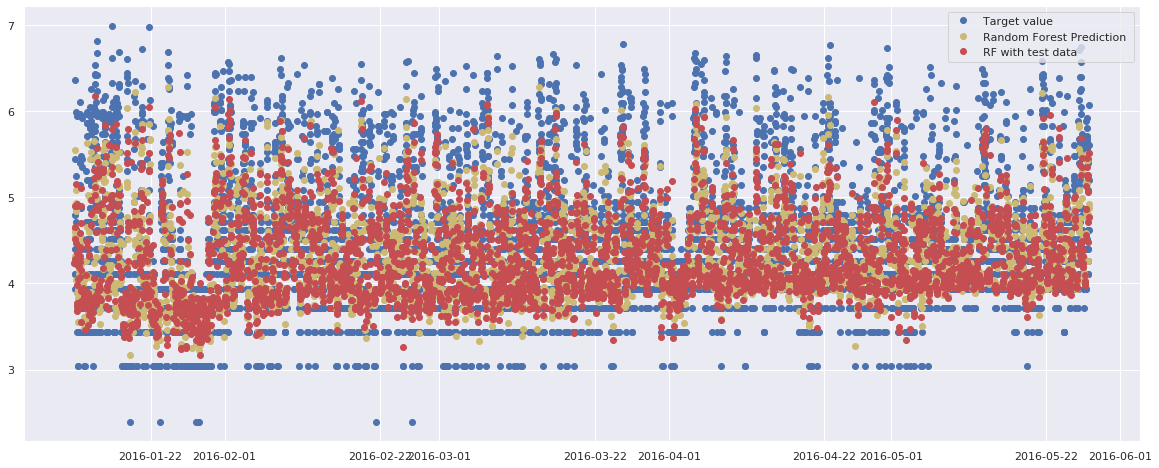

In [128]:
## Choosing RandomForestRegressor as best model and optimizing values below

## Plotting the results, comparing current best model with test data
rf = RandomForestRegressor(n_estimators=20)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_val)

y_pred_test = rf.predict(X_test)
score = r2_score(y_test,y_pred_test)
print(f"R2 score for RF on test data: {score}")

fig = plt.figure(figsize=(20,8))
plt.plot_date(df_train["time"],y_train,label='Target value',color='b')
plt.plot_date(df_val["time"],y_pred,label='Random Forest Prediction ', color='y')
plt.plot_date(df_test["time"],y_pred_test,label="RF with test data", color="r")
#
plt.legend(loc=1)
#fig.savefig("models.png")


### Training and Validation

In [129]:
### Poor attempt to improve the model below. I do not see any improvement


In [130]:

scaler = StandardScaler()

def train(X_train, y_train, n):
    #print(f"n = {n}")
    #scaler.fit(X_train)
    #X_train = scaler.transform(X_train)
    model = RandomForestRegressor(n_estimators = n)
    model.fit(X_train, y_train)
    return model

def predict(X_val,model):
    
    y_pred = model.predict(X_val)

    return y_pred

In [136]:
n_splits = 5
from tqdm.auto import tqdm
from sklearn.model_selection import KFold 

for n in tqdm([5,10,20,25,30]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    mae_scores = []
    r2_scores=[]

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]
        y_train = df_train.log_appliances.values
        y_val = df_val.log_appliances.values
        X_train=df_train[feature_cols]
        X_val = df_val[feature_cols]
        model = train(X_train, y_train, n=n)
        y_pred = predict(X_val, model)
        r2score = r2_score(y_test,y_pred_test)
        #print(f"R2 score for {n}: {r2score}")
        error = mean_absolute_error(y_pred,y_val)
        mae_scores.append(error)
        r2_scores.append(r2score)
    print(f'mean MAE for {n}: {np.mean(mae_scores)}')    
    print(f'mean R2 for {n}: {np.mean(r2_scores)}')

    


n = 5
n = 5
n = 5
n = 5
n = 5
mean MAE for 5: 0.28269876587518183
mean R2 for 5: 0.6201801413908403
n = 10
n = 10
n = 10
n = 10
n = 10
mean MAE for 10: 0.2689871864916341
mean R2 for 10: 0.6201801413908403
n = 20
n = 20
n = 20
n = 20
n = 20
mean MAE for 20: 0.258510171703858
mean R2 for 20: 0.6201801413908403
n = 25
n = 25
n = 25
n = 25
n = 25
mean MAE for 25: 0.25693379329686195
mean R2 for 25: 0.6201801413908403
n = 30
n = 30
n = 30
n = 30
n = 30
mean MAE for 30: 0.2559669719144718
mean R2 for 30: 0.6201801413908403



### Testing